# Galactic Disc Heating - MAIN Program

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from Schwarschild_function import schwarzschild_2
from Accelerations import *
from RK4_def_class import *

### Problem parameters 

In [2]:
# Mass of the black hole 
Mbh = 1e-1

# Parameters of the galaxy
a = 1         # semi-major axis
b = 0.05      # vertical scale height

In [3]:
#step definition
h=0.02
#number of points = N/h
N=50

### Initial conditions for the black hole and computation of its trajectory

Here, we want the black hole to oscillate along the z axis, allowing two passages into the center of the galaxy.

In [11]:
xi = 0
yi = 0
zi = 80*b
vxi = 0
vyi = 0
vzi = 0

Computation of the trajectory of the black hole using the integrator Runge Kutta at order 4th:

In [12]:
from RK4_def_class import RK4_BH

X_bh, Y_bh, Z_bh = RK4_BH(xi, yi, zi, vxi, vyi, vzi, h, N)

Plot of the trajectory of the black hole along the z-axis as a function of the time of the simulation:

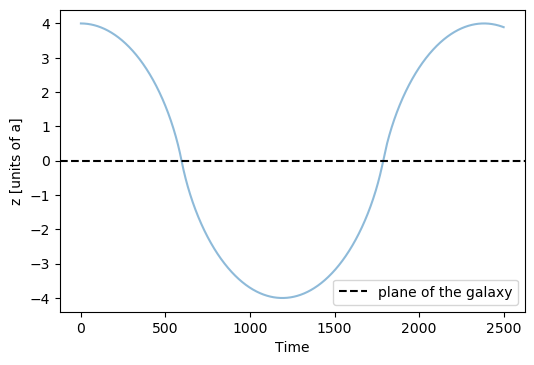

In [14]:
plt.figure(dpi=100)
plt.plot(Z_bh,alpha=0.5)
plt.axhline(y=0, linestyle='--', label='plane of the galaxy', color='black')
plt.xlabel('Time')
plt.ylabel('z [units of a]')
plt.legend()
plt.savefig('oscillation_bh.png')
plt.show()

### Creation of the galactic disc and  computation of stars trajectories

In [15]:
from RK4_def_class import MultipleStars
import time

In [16]:
# Numbers of stars in the galaxy
nb_star = 1000

# Timer to compute the execution time 
start_time = time.time()

# Creation of the galaxy using the class object MultipleStars
galaxy = MultipleStars(nb_star, a, b)

# Initial positions and velocities using Schwarschild functions for each star
x, y, z, vx, vy, vz = galaxy.x, galaxy.y, galaxy.z, galaxy.vx, galaxy.vy, galaxy.vz

# Computation of the trajectories for each stars using the Runge Kutta integrator
position, velocity = galaxy.RK4(h, N)                                             # without perturbation from the BH
position_pert, velocity_pert = galaxy.RK4_perturbation(h, N, X_bh, Y_bh, Z_bh)    # with perturbation from the BH

print('Computation time : ', time.time() - start_time, ' s')

Computation time :  617.9874799251556  s


### Plot of the initial conditions

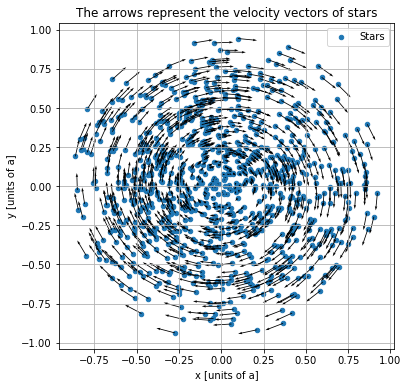

In [24]:
from mpl_toolkits import mplot3d

plt.figure(figsize=(6,6))
plt.scatter(x, y, s=20, label='Stars')
plt.quiver(x, y, vx, vy, scale=5, scale_units='xy', angles='xy')
plt.grid()
plt.xlabel('x [units of a]')
plt.ylabel('y [units of a]')
plt.legend()
plt.title('The arrows represent the velocity vectors of stars')
plt.show()

### 3D plot of the galaxy at initial time

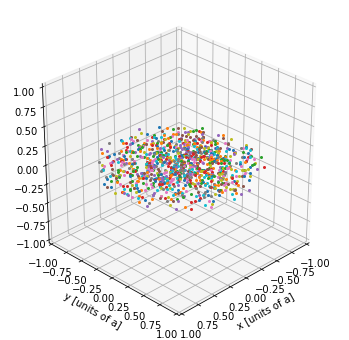

In [27]:
plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')
for i in range(0, nb_star):
    ax.scatter3D(position_pert[0,i,0],position_pert[1,i,0], position_pert[2,i,0], s=4)
ax.view_init(elev=30, azim=45)
plt.xlabel('x [units of a]')
plt.ylabel('y [units of a]')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
plt.show()

## Analyse at initial position

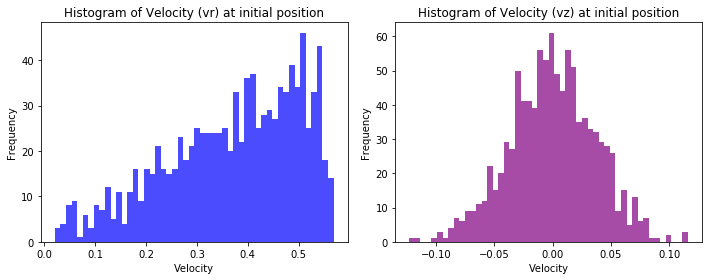

In [99]:
# Plot histograms
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(np.sqrt(velocity[0,:,0]**2+velocity[1,:,0]**2), bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Velocity (vr) at initial position')
plt.xlabel('Velocity')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(velocity[2,:,0], bins=50, color='purple', alpha=0.7)
plt.title('Histogram of Velocity (vz) at initial position')
plt.xlabel('Velocity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig('figure_new/histograms')
plt.show()

Computation of the velocity dispersions to verify if they match the expected value :

In [29]:
# Step 1: Calculate the mean velocity for each component
mean_vx = np.mean(velocity[0,:,0])
mean_vy = np.mean(velocity[1,:,0])
mean_vr = np.mean(np.sqrt(velocity[0,:,0]**2+velocity[1,:,0]**2))
mean_vz = np.mean(velocity[2,:,0])

# Step 2: Calculate squared differences between each velocity component and its mean
diff_vx = (velocity[0,:,0] - mean_vx)**2
diff_vy = (velocity[1,:,0] - mean_vy)**2
diff_vr = (np.sqrt(velocity[0,:,0]**2+velocity[1,:,0]**2) - mean_vr)**2
diff_vz = (velocity[2,:,0] - mean_vz)**2

# Step 3: Compute the variance for each component
variance_vx = np.mean(diff_vx)
variance_vy = np.mean(diff_vy)
variance_vr = np.mean(diff_vr)
variance_vz = np.mean(diff_vz)

# Step 4: Take the square root to obtain the velocity dispersion
dispersion_vx = np.sqrt(variance_vx)
dispersion_vy = np.sqrt(variance_vy)
dispersion_vr = np.sqrt(variance_vr)
dispersion_vz = np.sqrt(variance_vz)

print("Velocity Dispersion (vx):", dispersion_vx)
print("Velocity Dispersion (vy):", dispersion_vy)
print("Velocity Dispersion (vr):", dispersion_vr)
print("Velocity Dispersion (vz):", dispersion_vz)

Velocity Dispersion (vx): 0.27460953198332627
Velocity Dispersion (vy): 0.28037304161074955
Velocity Dispersion (vr): 0.13155663341221455
Velocity Dispersion (vz): 0.03658925948367766


In [36]:
from Schwarschild_function import density

print('Expected values :')

v_c = 1 # circular velocity 
print('Circular velocity : ', v_c)

sigma_vR = v_c/10
print('Velocity dispersion along R :', sigma_vR)

sigma_vz = np.sqrt(b*b*density(a, 0, a, b)) 
print('Velocity dispersion along z :', sigma_vz)

Expected values :
Circular velocity :  1
Velocity dispersion along R : 0.1
Velocity dispersion along z : 0.03752058675568103


The velocity dispersions recover the expected values.

## Analyse after each crossing of the black hole in the plan of the galaxy

This part has been automatized in case of many crossing of the black holes.

In [37]:
index=[]

print('Times of the simulation where a crossing happen :')
for i in range(len(Z_bh)-1):
    if Z_bh[i]<0 and Z_bh[i+1]>0:
        print(i+1)
        index.append(i+1)
    if Z_bh[i]>0 and Z_bh[i+1]<0:
        print(i+1)
        index.append(i+1)

print('Number of crossing of the BH in the plan of the galaxy :', len(index))

Times of the simulation where a crossing happen :
595
1787
Number of crossing of the BH in the plan of the galaxy : 2


### Velocity dispersion as a function of time:

In [93]:
list_sigma_vx=[]
list_sigma_vy=[]
list_sigma_vr=[]
list_sigma_vz=[]

for i in range(0,np.shape(velocity)[2]):    
    # Step 1: Calculate the mean velocity for each component
    mean_vx = np.mean(velocity_pert[0,:,i])
    mean_vy = np.mean(velocity_pert[1,:,i])
    mean_vr = np.mean(np.sqrt(velocity_pert[0,:,i]**2+velocity_pert[1,:,i]**2))
    mean_vz = np.mean(velocity_pert[2,:,i])

    # Step 2: Calculate squared differences between each velocity component and its mean
    diff_vx = (velocity_pert[0,:,i] - mean_vx)**2
    diff_vy = (velocity_pert[1,:,i] - mean_vy)**2
    diff_vr = (np.sqrt(velocity_pert[0,:,i]**2+velocity_pert[1,:,i]**2) - mean_vr)**2
    diff_vz = (velocity_pert[2,:,i] - mean_vz)**2

    # Step 3: Compute the variance for each component
    variance_vx = np.mean(diff_vx)
    variance_vy = np.mean(diff_vy)
    variance_vr = np.mean(diff_vr)
    variance_vz = np.mean(diff_vz)

    # Step 4: Take the square root to obtain the velocity dispersion
    list_sigma_vx.append(np.sqrt(variance_vx))
    list_sigma_vy.append(np.sqrt(variance_vy))
    list_sigma_vr.append(np.sqrt(variance_vr))
    list_sigma_vz.append(np.sqrt(variance_vz))

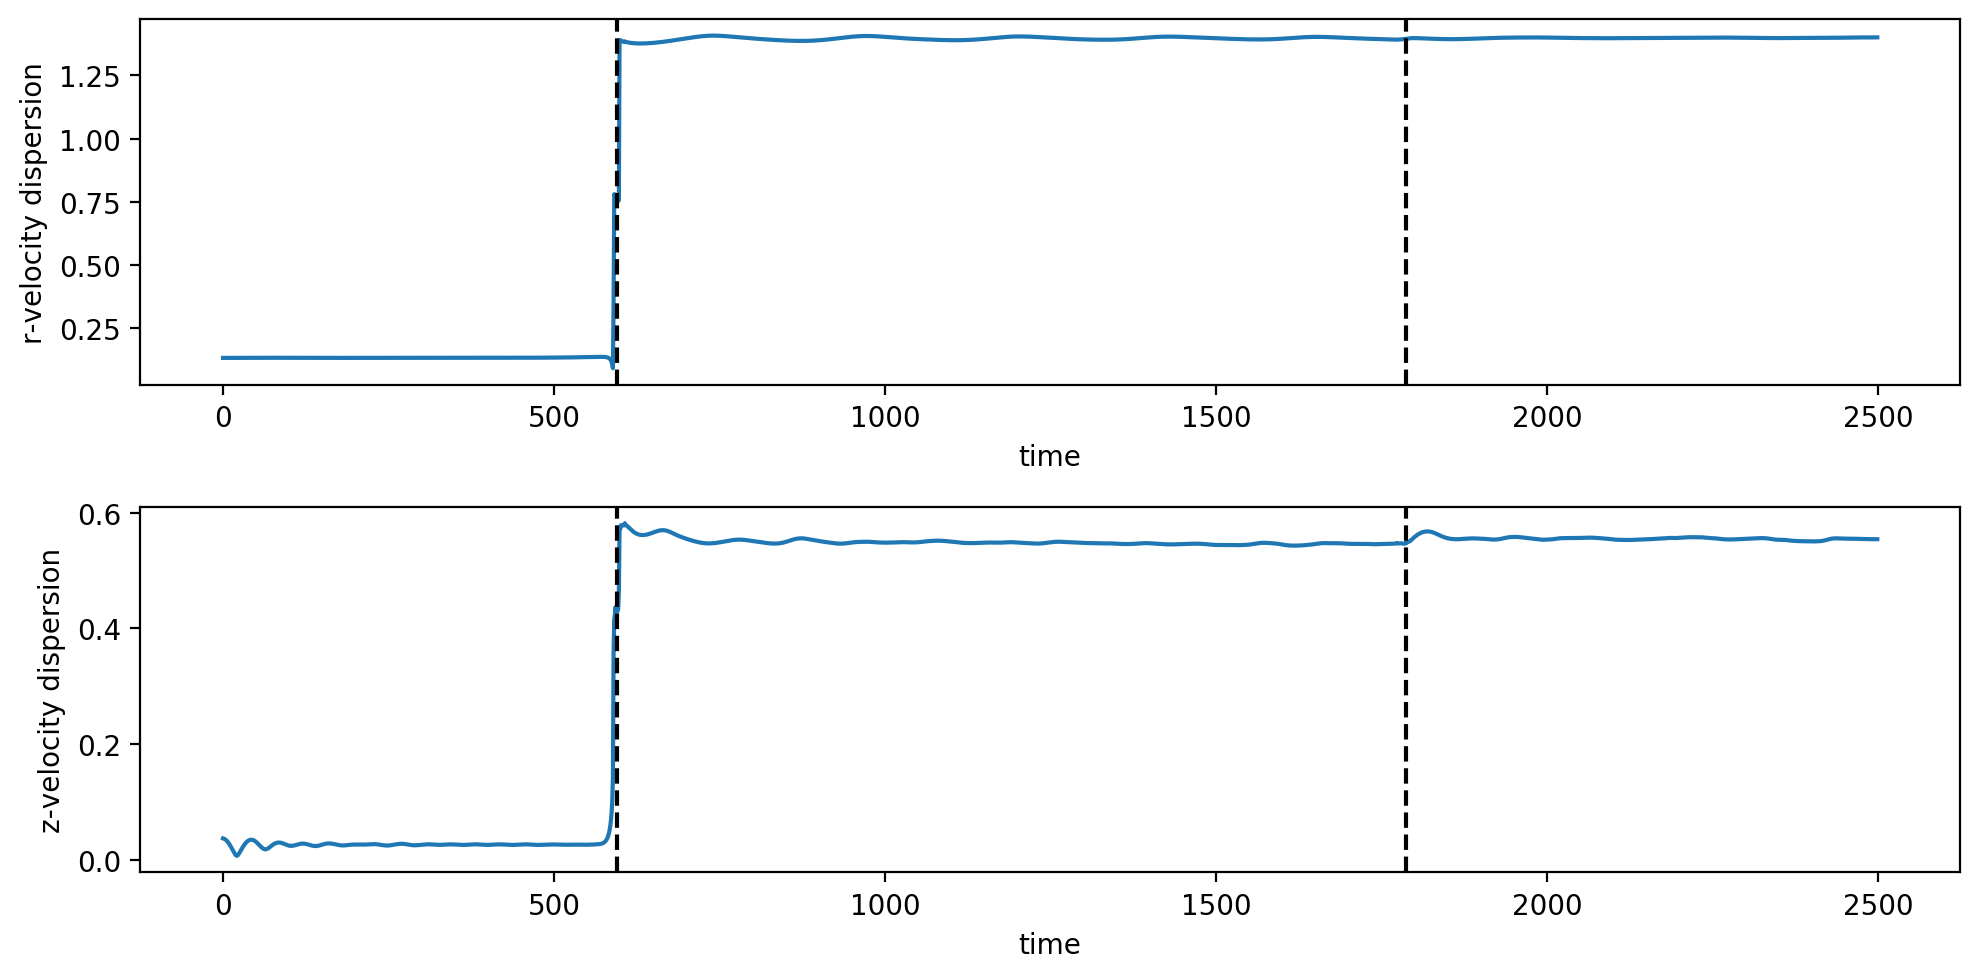

In [95]:
plt.figure(figsize=(10,5),dpi=200)

plt.subplot(2, 1, 1)
plt.plot(list_sigma_vr)
plt.xlabel('time')
plt.ylabel('r-velocity dispersion')
for i in range(0,len(index)):
    plt.axvline(x=index[i], color='black', linestyle='--')

plt.subplot(2, 1, 2)
plt.plot(list_sigma_vz)
plt.xlabel('time')
plt.ylabel('z-velocity dispersion')
for i in range(0,len(index)):
    plt.axvline(x=index[i], color='black', linestyle='--')

plt.tight_layout()
plt.savefig('figure_new/dispersion_all_stars')
plt.show()

### Computation of the mechanical energy

In [43]:
def potential(x,y,z):
    R=np.sqrt(x*x+y*y)
    return -1/(np.sqrt(R*R+(a+np.sqrt(z*z+b*b))**2))

def potential_BH(x,y,z,x_bh,y_bh,z_bh):
    R=np.sqrt(x*x+y*y)
    return -1/(np.sqrt(R*R+(a+np.sqrt(z*z+b*b))**2)) - Mbh/np.sqrt((x_bh-x)**2 + (y_bh-y)**2 + (z_bh-z)**2)

In [44]:
list_energy=np.zeros((np.shape(position)[2],nb_star))

for star in range(0,nb_star):
    for k in range(0,np.shape(position)[2]):
        R2=position_pert[0,star,k]**2+position_pert[1,star,k]**2
        S=np.sqrt(R2+(a+b)**2)
        omega=pow(S,-3/2)
        E=0.5*(velocity_pert[0,star,k]**2+velocity_pert[1,star,k]**2+velocity_pert[2,star,k]**2)+potential_BH(position_pert[0,star,k],position_pert[1,star,k],position_pert[2,star,k],X_bh[k], Y_bh[k], Z_bh[k])
        list_energy[k,star]=E

Plot of the mechanical energy for all the stars :

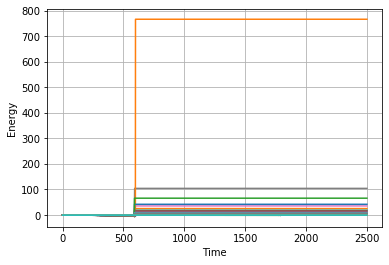

In [46]:
plt.figure()
for i in range(0, nb_star):
    plt.plot(list_energy[:,i])
plt.xlabel('Time')
plt.ylabel('Energy')
plt.grid()
plt.show()

We can see that the mechanical energy becomes positive for a certain amount of stars. These stars are no more bounded to the galaxy and are ejected. We need to remove them to do the analyses. In the next plot, we remove these unbound stars :

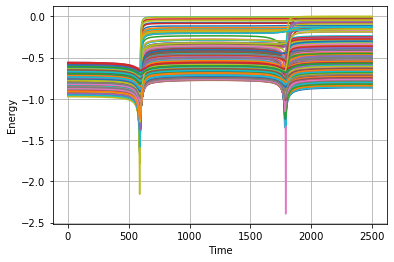

In [48]:
plt.figure()
for star in range(0,nb_star):
    if all(list_energy[:,star]<0):
        plt.plot(list_energy[:,star])
plt.xlabel('Time')
plt.ylabel('Energy')
plt.grid()
plt.show()

### Removing the unbound stars  

In [50]:
nb_good_stars=0
for star in range(0,nb_star):
    if all(list_energy[:,star]<0):
        nb_good_stars = nb_good_stars+1
print('The number of unbound stars is : ', nb_star-nb_good_stars)

The number of unbound stars is :  57


In [57]:
new_position3D = np.zeros((3, nb_good_stars, int(N//h)+1))
new_velocity3D = np.zeros((3, nb_good_stars, int(N//h)+1))

i=0
for star in range(0,nb_star):
    if all(list_energy[:,star]<0):
        new_position3D[:,i,:]=position_pert[:,star,:]
        new_velocity3D[:,i,:]=velocity_pert[:,star,:]
        i=i+1

### Recomputation of the velocity dispersions

In [96]:
list_sigma_vx=[]
list_sigma_vy=[]
list_sigma_vr=[]
list_sigma_vz=[]

for i in range(0,np.shape(velocity)[2]):    
    # Step 1: Calculate the mean velocity for each component
    mean_vx = np.mean(new_velocity3D[0,:,i])
    mean_vy = np.mean(new_velocity3D[1,:,i])
    mean_vr = np.mean(np.sqrt(new_velocity3D[0,:,i]**2+new_velocity3D[1,:,i]**2))
    mean_vz = np.mean(new_velocity3D[2,:,i])

    # Step 2: Calculate squared differences between each velocity component and its mean
    diff_vx = (new_velocity3D[0,:,i] - mean_vx)**2
    diff_vy = (new_velocity3D[1,:,i] - mean_vy)**2
    diff_vr = (np.sqrt(new_velocity3D[0,:,i]**2+new_velocity3D[1,:,i]**2) - mean_vr)**2
    diff_vz = (new_velocity3D[2,:,i] - mean_vz)**2

    # Step 3: Compute the variance for each component
    variance_vx = np.mean(diff_vx)
    variance_vy = np.mean(diff_vy)
    variance_vr = np.mean(diff_vr)
    variance_vz = np.mean(diff_vz)

    # Step 4: Take the square root to obtain the velocity dispersion
    list_sigma_vx.append(np.sqrt(variance_vx))
    list_sigma_vy.append(np.sqrt(variance_vy))
    list_sigma_vr.append(np.sqrt(variance_vr))
    list_sigma_vz.append(np.sqrt(variance_vz))

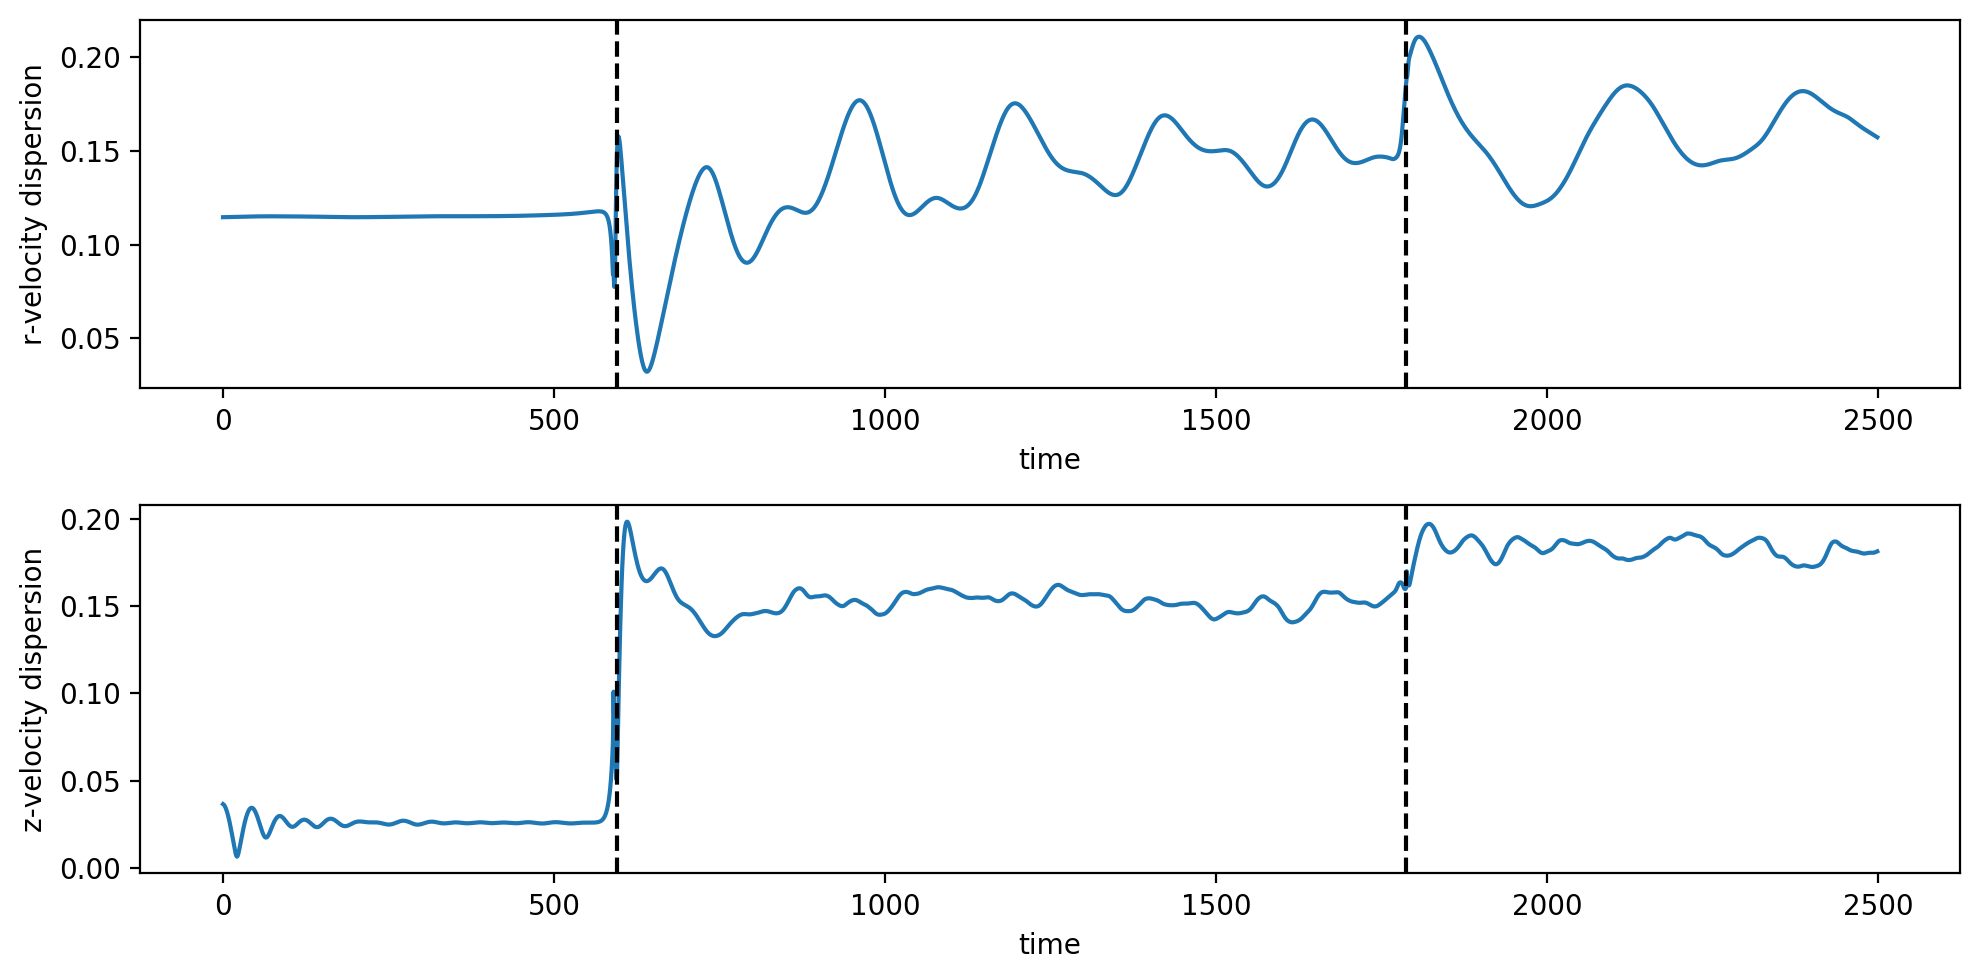

In [97]:
plt.figure(figsize=(10,5),dpi=200)

plt.subplot(2, 1, 1)
plt.plot(list_sigma_vr)
plt.xlabel('time')
plt.ylabel('r-velocity dispersion')
for i in range(0,len(index)):
    plt.axvline(x=index[i], color='black', linestyle='--')

plt.subplot(2, 1, 2)
plt.plot(list_sigma_vz)
plt.xlabel('time')
plt.ylabel('z-velocity dispersion')
for i in range(0,len(index)):
    plt.axvline(x=index[i], color='black', linestyle='--')

plt.tight_layout()
plt.savefig('figure_new/dispersion')
plt.show()

We can clearly see a difference between the velocity dispersions before and after romving the stars.

### Computation of kinetic energy and comparison between low epicyclic amplitude stars and other stars

In [60]:
list_kinetic_energy = np.zeros((np.shape(new_position3D)[2],nb_good_stars))
list_total_energy = np.zeros((np.shape(new_position3D)[2],nb_good_stars))

i=0

for star in range(0,nb_good_stars):
    for k in range(0,np.shape(new_position3D)[2]):
        R2=new_position3D[0,star,k]**2+new_position3D[1,star,k]**2
        S=np.sqrt(R2+(a+b)**2)
        omega=pow(S,-3/2)
        E_kin=0.5*(new_velocity3D[0,star,k]**2+new_velocity3D[1,star,k]**2+new_velocity3D[2,star,k]**2)
        E=0.5*(new_velocity3D[0,star,k]**2+new_velocity3D[1,star,k]**2+new_velocity3D[2,star,k]**2)+potential_BH(new_position3D[0,star,k],new_position3D[1,star,k],new_position3D[2,star,k],X_bh[k], Y_bh[k], Z_bh[k])
        list_kinetic_energy[k,i]=E_kin
        list_total_energy[k,i]=E
    i=i+1

We compute the minimum and maximum amplitude in the kinetic energy before the perturbation:

In [61]:
amplitude=[]
for i in range(0, nb_good_stars):
    amp=np.max(list_kinetic_energy[:500,i])-np.min(list_kinetic_energy[:500,i])
    amplitude.append(amp)
    
min_amplitude=np.min(amplitude)
max_amplitude=np.max(amplitude)
    
print(max_amplitude)
print(min_amplitude)

0.01802675554026914
0.00021545214206491678


We compute the mean kinetic energy before the first passage, between the two crossings, and after the 2nd passage. 

In [103]:
mean_kinetic_before = []
mean_kinetic = []
mean_kinetic2 = []

for i in range(0, nb_good_stars):
    mean_before = np.mean(list_kinetic_energy[:index[0],i])
    mean_kinetic_before.append(mean_before)
    mean = np.mean(list_kinetic_energy[index[0]:index[1],i])
    mean_kinetic.append(mean)
    mean2 = np.mean(list_kinetic_energy[index[1]:,i])
    mean_kinetic2.append(mean2)

We compute the difference in mean kinetic energy before and after the passage of the black hole for low epyclic amplitude stars, defined arbitrarily as amplitude lower than 7 times the minimal amplitude.

In [107]:
import statistics 
    
diff = []

count_low_aplitude_stars = 0
for i in range(0, nb_good_stars):
    if amplitude[i]>min_amplitude and amplitude[i]<(7*min_amplitude):
        diff.append(mean_kinetic[i] - mean_kinetic_before[i])
        count_low_aplitude_stars = count_low_aplitude_stars + 1
        
print('Number of low amplitude epicyclic stars:', count_low_aplitude_stars)

mean_diff = np.mean(diff)
sigma_diff = statistics.pstdev(diff)
        
print('mean diff low epicyclic amplitude:', mean_diff)
print('std :', sigma_diff)

Number of low amplitude epicyclic stars: 122
mean diff low epicyclic amplitude: 0.07815895243466195
std : 0.04029820132863143


In [81]:
diff2 = []

for i in range(0, nb_good_stars):
    diff2.append(mean_kinetic[i] - mean_kinetic_before[i])

mean_diff2 = np.mean(diff2)
sigma_diff2 = statistics.pstdev(diff2)
print('mean :', mean_diff2)
print('std :', sigma_diff2)

mean : 0.03726546186077624
std : 0.03872531919052194


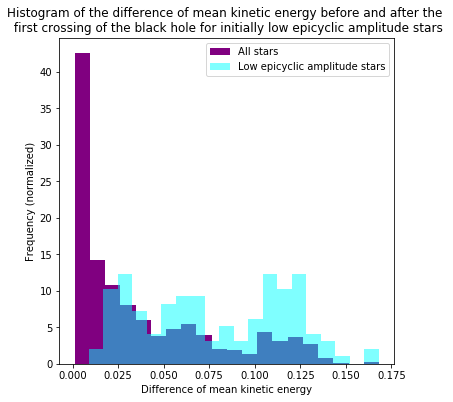

In [111]:
plt.figure(figsize=(6,6))
plt.hist(diff2, density=True, alpha=1, color='purple',bins=20, label='All stars')
plt.hist(diff, density=True,alpha=0.5, color='cyan',bins=20, label='Low epicyclic amplitude stars')
plt.title('Histogram of the difference of mean kinetic energy before and after the \n first crossing of the black hole for initially low epicyclic amplitude stars')
plt.xlabel('Difference of mean kinetic energy')
plt.ylabel('Frequency (normalized)')
plt.legend()
plt.savefig('figure_new/hist_kineticE_oscill')
plt.show()

In [106]:
diff3 = []

for i in range(0, nb_good_stars):
    if amplitude[i]>min_amplitude and amplitude[i]<(7*min_amplitude):
        diff3.append(mean_kinetic2[i] - mean_kinetic[i])

mean_diff3 = np.mean(diff3)
sigma_diff3 = statistics.pstdev(diff3)
        
print('mean diff low epicyclic amplitude:', mean_diff3)
print('std :', sigma_diff3)

mean diff low epicyclic amplitude: 3.73197753379901e-05
std : 0.04741299735154718


In [108]:
diff4 = []

for i in range(0, nb_good_stars):
    diff4.append(mean_kinetic2[i] - mean_kinetic[i])

mean_diff4 = np.mean(diff4)
sigma_diff4 = statistics.pstdev(diff4)
print('mean :', mean_diff4)
print('std :', sigma_diff4)

mean : 0.006005862386076482
std : 0.028405317645535905


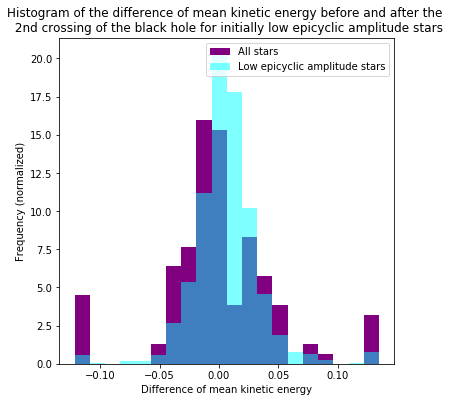

In [112]:
plt.figure(figsize=(6,6))
plt.hist(diff3, density=True, alpha=1, color='purple',bins=20, label='All stars')
plt.hist(diff4, density=True,alpha=0.5, color='cyan',bins=20, label='Low epicyclic amplitude stars')
plt.title('Histogram of the difference of mean kinetic energy before and after the \n 2nd crossing of the black hole for initially low epicyclic amplitude stars')
plt.xlabel('Difference of mean kinetic energy')
plt.ylabel('Frequency (normalized)')
plt.legend()
plt.savefig('figure_new/hist_kineticE_oscill_2ndcross')
plt.show()

## Animation

In [113]:
nb_frame = int(int((N//h)+1)/10)

def reduce_anim(array):
    array_anim = np.zeros((3, galaxy.number_stars, nb_frame))
    size=np.shape(array)[2]
    i=0
    j=0
    while j<(nb_frame):
        array_anim[:,:,j] = array[:,:,i]
        j=j+1
        i=i+10
    return array_anim

position_anim = reduce_anim(position)
velocity_anim = reduce_anim(velocity)
position_pert_anim = reduce_anim(position_pert)
velocity_pert_anim = reduce_anim(velocity_pert)

In [114]:
def reduce_BH_anim(liste):
    list_anim = []
    size=len(liste)
    i=0
    j=0
    while j<(nb_frame):
        list_anim.append(liste[i])
        j=j+1
        i=i+10
    return list_anim

X_bh_anim = reduce_BH_anim(X_bh)
Y_bh_anim = reduce_BH_anim(Y_bh)
Z_bh_anim = reduce_BH_anim(Z_bh)

In [115]:
print(nb_frame)

250


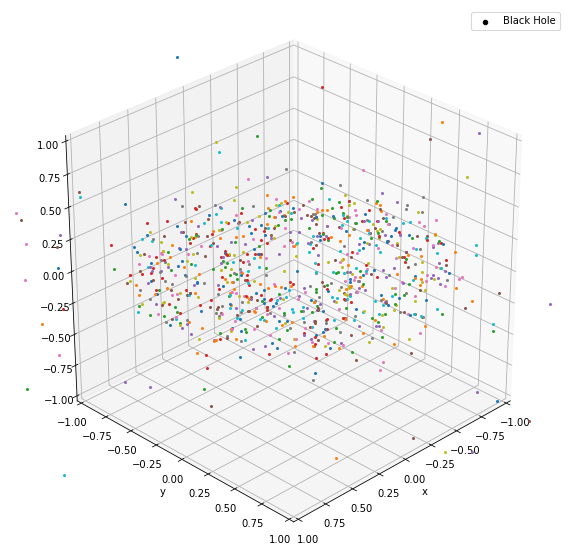

In [116]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
for i in range(0, nb_star):
    ax.scatter3D(position_pert_anim[0,i,249],position_pert_anim[1,i,249], position_pert_anim[2,i,249], s=4)
ax.scatter(X_bh_anim[249],Y_bh_anim[249],Z_bh_anim[249], label='Black Hole', color='black')
ax.view_init(elev=30, azim=45)
plt.xlabel('x')
plt.ylabel('y')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
plt.legend()
plt.show()

Frame 0: Rendering time = 2.0689334869384766 seconds


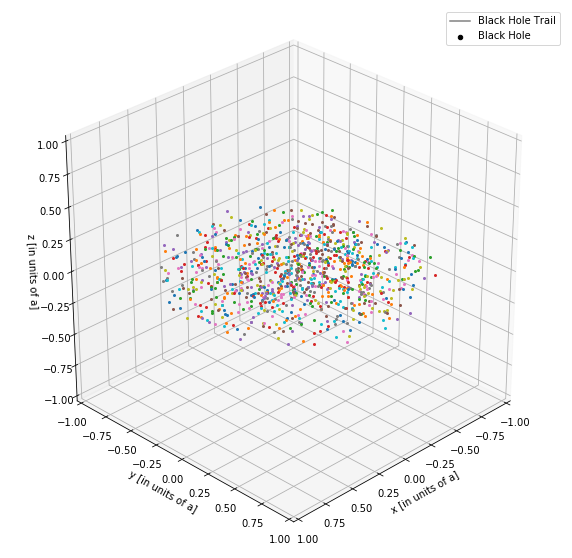

In [117]:
from matplotlib.animation import FuncAnimation
import time

anim=1

if anim==1:

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')

    # Function to update the plot for each frame
    def update(frame):
        start_time = time.time()
        
        ax.clear()  # Clear the previous frame's content

        for i in range(0, nb_star):
            ax.scatter3D(position_pert_anim[0,i,frame],position_pert_anim[1,i,frame], position_pert_anim[2,i,frame], s=4)
        ax.scatter(X_bh_anim[frame],Y_bh_anim[frame],Z_bh_anim[frame], label='Black Hole', color='black')
        ax.plot(X_bh_anim[:frame+1], Y_bh_anim[:frame+1],Z_bh_anim[:frame+1], color='black', alpha=0.5, label='Black Hole Trail')
        ax.view_init(elev=30, azim=45)
        ax.set_xlabel('x [in units of a]')
        ax.set_ylabel('y [in units of a]')
        ax.set_zlabel('z [in units of a]')
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)
        ax.set_zlim(-1, 1)
        ax.legend()

        print(f"Frame {frame}: Rendering time = {time.time() - start_time} seconds")

    # Set the number of frames
    num_frames = nb_frame

    # Create the animation
    animation = FuncAnimation(fig, update, frames=num_frames, interval=30)

    # Save the animation as a gif
    #animation.save('stellar_orbit.gif')

    # Show the plot
    plt.show()


In [118]:
if anim==1:
    # Save the animation as a gif
    animation.save('stellar_orbit_BH_center_2cross.gif',fps=10)

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


Frame 0: Rendering time = 2.186568021774292 seconds
Frame 0: Rendering time = 2.2445638179779053 seconds
Frame 1: Rendering time = 2.1248443126678467 seconds
Frame 2: Rendering time = 2.3048949241638184 seconds
Frame 3: Rendering time = 1.9218685626983643 seconds
Frame 4: Rendering time = 2.120689630508423 seconds
Frame 5: Rendering time = 2.3477232456207275 seconds
Frame 6: Rendering time = 2.217346668243408 seconds
Frame 7: Rendering time = 2.1939237117767334 seconds
Frame 8: Rendering time = 2.1503703594207764 seconds
Frame 9: Rendering time = 2.064401149749756 seconds
Frame 10: Rendering time = 1.9163861274719238 seconds
Frame 11: Rendering time = 2.0084145069122314 seconds
Frame 12: Rendering time = 2.0815181732177734 seconds
Frame 13: Rendering time = 2.08115553855896 seconds
Frame 14: Rendering time = 2.1348366737365723 seconds
Frame 15: Rendering time = 2.0283098220825195 seconds
Frame 16: Rendering time = 2.0142741203308105 seconds
Frame 17: Rendering time = 1.9973301887512207

Frame 152: Rendering time = 2.1268162727355957 seconds
Frame 153: Rendering time = 1.8505785465240479 seconds
Frame 154: Rendering time = 2.048182964324951 seconds
Frame 155: Rendering time = 2.278611660003662 seconds
Frame 156: Rendering time = 2.143038511276245 seconds
Frame 157: Rendering time = 2.1981852054595947 seconds
Frame 158: Rendering time = 2.216076374053955 seconds
Frame 159: Rendering time = 2.246145725250244 seconds
Frame 160: Rendering time = 2.2047297954559326 seconds
Frame 161: Rendering time = 2.1067495346069336 seconds
Frame 162: Rendering time = 2.203993082046509 seconds
Frame 163: Rendering time = 2.242130756378174 seconds
Frame 164: Rendering time = 2.1316120624542236 seconds
Frame 165: Rendering time = 2.131695508956909 seconds
Frame 166: Rendering time = 2.0414788722991943 seconds
Frame 167: Rendering time = 2.5692896842956543 seconds
Frame 168: Rendering time = 2.699213981628418 seconds
Frame 169: Rendering time = 2.0904576778411865 seconds
Frame 170: Renderin